# **Asteroid light curve fitting using Lomb-Scargle Periodogram**

> **Author**: [Miguel R. Alarcón](https://twitter.com/mralarcon_) $($[@miguelralarcon](https://github.com/miguelralarcon)$)$\
 **Affiliation**: Universidad de La Laguna\
**Date**: Dec. 2019\
Access to this notebook is open in this [Google Colab](https://colab.research.google.com/drive/1ApYVu1Uw__ebdhHFReuBjSMyj22UL-Bm).

Asteroids appear frequently in the inner Solar System and have been studied intensively by astronomers through
the years. Properties of asteroids such as orbital characteristics, composition, age, rotation, color, mass and size are interesting to study. This information can be used in various fields of astronomical research. For example, asteroids can provide a lot of information about the forming and development of planetary system ([Asphaug et al. 2006](#scrollTo=I1JUdFfcUF3f&line=2&uniqifier=1)). Also collisions between asteroids and their consequences can be important in planetary formation. Therefore asteroids may even hold the
clue about the origin of life on earth ([Rivkin & Emery 2010](#scrollTo=I1JUdFfcUF3f&line=2&uniqifier=1)). While asteroids can be the key to understanding the origin of life, there
is also a chance they will destroy life. Some asteroids cross Earth’s orbit and are called near-earth asteroids. They
have a probability to strike Earth and cause serious damage ([Chapman 2004](#scrollTo=I1JUdFfcUF3f&line=2&uniqifier=1)). For this reason, it is important to know as much as
possible about these objects.

Most asteroids do not have a symmetrical shape or a constant albedo. This results in a fluctuation of the magnitude of the asteroid while it is rotating. Because the rotation is periodic this results in a periodic magnitude difference. Thus the rotational period can be determined from measuring the light curve and fitting the best period (see Fig. [1](#scrollTo=2q0ej81w_Wxk&line=28&uniqifier=1) for details). That is what is done in this Notebook.

<div>
<center>
<img src="https://pbs.twimg.com/media/Csdj3ynWcAATauo.jpg" width="700" height="400"/>
</center>
</div>

<center>

**Figure 1.** 2016 LX48 light curve from Astronomical Observatory Aosta Valley.
</center>


-- --

## **First steps**

Before you start, make sure to open this Colab notebook in "*PlayGround Mode*" (top left). Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1f6dvuu9mf-h17Ovv_Zqbiku03IsPopJa?usp=sharing) and add it to your Google Drive by following these steps:
*   Go to your drive 
*   Find shared folder ("*Shared with me*" link)
*   Right click it
*   Click "*Add to My Drive*"


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Install and import packages
!pip install julian
!pip install astroquery
!pip install astropy
import julian
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astroquery.jplhorizons import Horizons
from astropy.stats import LombScargle
from scipy.optimize import curve_fit

-- --

## **Data**

It is provided a file which contains the measures of apparent magnitudes (in V) with uncertainties for different nights (given in Julian Date) of the Apollo-type asteoroid 2016 LX48 downloaded from [ALCDEF](http://alcdef.org). 2016 LX48 was discovered by Pan-STARRS 1 on 2016 June 11 and it is classified as a "Potentially Hazardous Asteroid" by the [Minor Planet Center](https://www.minorplanetcenter.net/mpec/K16/K16LC2.html).

In [ ]:
# Define path to file
file_path = '/content/drive/My Drive/LightCurve-Fitting/'
file_name = '2016LX48.txt'
object_name = '2016 LX48'       # MPC designation

# Read photometry file
with open(file_path + file_name,'r') as phot_file:
  phot_file_lines = np.array(phot_file.read().splitlines())

# Extract observation windows
obs_windows_start = np.where(phot_file_lines == 'ENDMETADATA')[0]
obs_windows_end = np.append(np.where(phot_file_lines ==
                                     'STARTMETADATA')[0][1:],len(phot_file_lines))
obs_windows_num = len(obs_windows_start)

In [4]:
# Convert string to multi dimensional array
phot, phot_jd = [], []
for i in range(obs_windows_num):
  lines = phot_file_lines[obs_windows_start[i]+1:obs_windows_end[i]-1]
  phot_avg = np.array(lines[int(len(lines)/2)][5:].split('|')).astype(float)
  lines_lst = [np.array(ln[5:].split('|')).astype(float) for ln in lines]
  phot.append(np.array(lines_lst))
  phot_jd.append(np.mean(np.array(lines_lst)[:,0]))

# Show the basic information about the dataset
print('The object %s has been observed during %i different windows:'%
      (object_name, obs_windows_num))
for i in range(obs_windows_num):
  mean_jd = np.mean(phot[i][:,0])
  mean_date = julian.from_jd(phot_jd[i], fmt='jd')
  meas_num = len(phot[i])
  time_interv_h = datetime.timedelta(phot[i][-1,0] -
                                     phot[i][0,0]).total_seconds()/3600
  print('Set %i: %s - %i measures in %.2f hours' %
        (i+1,mean_date,meas_num,time_interv_h))

The object 2016 LX48 has been observed during 10 different windows:
Set 1: 2016-09-09 03:46:45.407997 - 56 measures in 1.14 hours
Set 2: 2016-09-09 04:48:07.198287 - 67 measures in 1.21 hours
Set 3: 2016-09-09 05:34:36.281610 - 27 measures in 0.52 hours
Set 4: 2016-09-10 03:30:42.971174 - 70 measures in 1.05 hours
Set 5: 2016-09-10 04:35:29.250316 - 73 measures in 1.15 hours
Set 6: 2016-09-10 05:42:02.717048 - 76 measures in 1.32 hours
Set 7: 2016-09-11 03:40:41.192029 - 67 measures in 1.06 hours
Set 8: 2016-09-11 04:42:38.479571 - 73 measures in 1.20 hours
Set 9: 2016-09-11 05:52:30.775198 - 83 measures in 1.30 hours
Set 10: 2016-09-11 06:33:45.208126 - 22 measures in 0.39 hours


-- --

## **Preliminary light curve**

Let's plot  the light curve in magnitude against julian date to see how the dataset is spanned over time

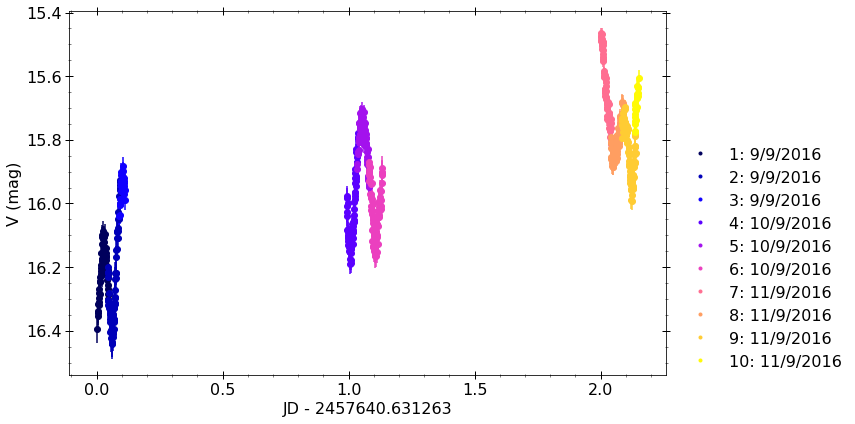

In [5]:
def plotter(ax, x, y, yerr, xlabel, ylabel, color, label, fontsize,
            mk='.', lstyle='None', rast=False,aph=1):
  # Format plt.axes for plotting the light curve
  ax.plot(x,y,color=color,label=label,marker=mk,linestyle=lstyle,
          rasterized=rast,alpha=aph)
  if type(yerr) == np.ndarray: ax.errorbar(x,y,yerr=yerr,fmt='o',color=color,alpha=aph)
  if label != None: ax.legend(loc=(1.02,0),fontsize=fontsize,frameon=False)
  ax.set_xlabel(xlabel,fontsize=fontsize)
  ax.set_ylabel(ylabel,fontsize=fontsize)

  ax.minorticks_on()
  ax.tick_params(axis='both',direction='inout',which='minor',
                 length=3,width=.5,labelsize=fontsize)
  ax.tick_params(axis='both',direction='inout',which='major',
                 length=8,width=1,labelsize=fontsize)
  ax.yaxis.set_ticks_position('both')
  ax.xaxis.set_ticks_position('both')
  

# Plot the light curve
plt.figure(figsize=(12,6))
ax = plt.subplot(1, 1, 1)
colormap = plt.cm.get_cmap('gnuplot2', 256)
co = colormap(np.linspace(0, 1, obs_windows_num+2))
fontsize = 16
x0 = phot[0][0,0]
for i,meas in enumerate(phot):
  x = meas[:,0] - x0              
  y = meas[:,1]
  yerr = meas[:,2]    # If magnitude errors must be ignore, type yerr = None
  meas_jd = julian.from_jd(phot_jd[i], fmt='jd')
  xlabel, ylabel = 'JD - ' + str(x0), 'V (mag)'
  color = co[i+1]
  label = '%i: %i/%i/%i' % (i+1, meas_jd.day, meas_jd.month,meas_jd.year)
  plotter(ax, x, y, yerr, xlabel, ylabel, color, label, fontsize)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Figure 2.** 2016 LX48 preliminary light curve, representing apparent magnitude in V against days from the first observation. In color are represented the different observation windows.

Several things should be notice here. In addition to an oscillatory behavior, due to its rotation, it seems that the brightness of the asteroid increases (inverse of its magnitude) throughout the days. Moreover, there are clear gaps between the sets of observations, corresponding to different days. The first effect has to do with the geometric position of the asteroid in its orbit. The second is the motivation of this practice. In astronomy, it is very common that the observation time of a transient object are shorter than its period. It is therefore necessary to be able to shift the observations to represent them, instead of against time, with against their rotation phase, thus being able to find the period.

## **Defining an absolute magnitude**

Apart from the rotation, there more effects that can produce changes in the apparent magnitude of and asteroid. For this reason, it is necessary to define an absolute magnitude and correct photometrical measures across the observing time.
Asteroids shine due to the Sun's light reflecting off their surface, and their brightness might vary due to one or more of the following factors: The asteroid's distance to us is changing (closer objects appear brighter). The asteroid's phase, just like the Moon's, is changing as it orbits around the Sun (the larger the area of the asteroid that is illuminated, as seen from Earth, the brighter it will appear).

### **Distance correction**

As an asteroid orbits the Sun, its distances from the Sun and Earth change. This means that all other things being equal, the asteroid naturally changes brightness over time, getting brighter as it gets closer to Earth, but only if not also getting farther away from the Sun. To account for changing distances, a correction can be applied:

$$
\delta V_{dist} = -5 log_{10} (r \cdot d) \quad \quad (1)
$$
where $r$ and $d$ are the asteroid-Sun and asteroid-Earth distance (in AU) respectively.

In [ ]:
def dV_dist(r, d):
  # magnitude correction for asteroid-Sun and asteroid-Earth changing distance
  return -5*np.log10(r*d)

### **Phase angle correction**

Moreover, the asteroid's phase, just like the Moon's, is changing as it orbits around the Sun (the larger the area of the asteroid that is illuminated, as seen from Earth, the brighter it will appear). The correction that must be introduced here is no as simple as the others. We follow the function defined by [Bowell (1989)](#scrollTo=I1JUdFfcUF3f&line=2&uniqifier=1):

$$
\delta V_{\alpha} = +2.5 log_{10}\left\{(1-G)\phi_i(\alpha) + G\phi_2(\alpha)\right\}
$$ $$
\phi_i(\alpha) = exp\{-A_i ~tan(\alpha/2)^{B_i}\}  \quad \quad \quad (2)
$$ $$
A_1 = 3.33, A_2 = 1.87, B_1 = 0.63, B_2 = 1.22, 
$$
where $G$ is the "slope parameter" (related to the opposition effect) and $\alpha$ the phase angle.

In [ ]:
def phi(alpha, A, B):
  # phase function
  return np.exp(-A*(np.tan(alpha*np.pi/(180*2))**B))

def dV_alpha(alpha, G):
  # magnitude correction for phase angle
  A1, A2, B1, B2 = 3.33, 1.87, 0.63, 1.22
  q = (1-G)*phi(alpha,A1,B1) + G*phi(alpha,A2,B2)
  return 2.5*np.log10(q)

### **Light-time correction**

As discussed above, an asteroid’s distance from Earth is constantly changing. Since light travels at a finite speed, you must correct the timing of the observations so that they are referenced to a fixed distance. This is done by subtracting the light-time from the JD of the observation so that the JD is referenced to when the light left the asteroid not when it arrived at Earth.

$$
\delta t = -0.005778 \cdot d \quad \quad (3)
$$
where $d$ is again the asteroid-Earth distance (in AU) and the constant is the speed of light in AU/day.

In [ ]:
def dt(d):
  # julian day correction for lihgt-time effect
  return -0.005778*d

Orbital parameters of the asteroid (r, d, alpha and G) are taken from the JPL Horizons database thanks to the Python package `astroquery.jplhorizons` imported before. Putting all together:

In [ ]:
# Distance, sun phase and light-travel correction
def correction(obj_name, photometry):
  # Apply corrections to apparent magnitude and julian date

  phot_corr = np.array(photometry)
  # Import orbital parameters
  obj = Horizons(id=obj_name, location='500', epochs=photometry[:,0],
                 id_type='designation')
  eph = obj.ephemerides()
  r = np.array(eph['r']).astype(float)             # AU
  d = np.array(eph['delta']).astype(float)         # AU
  alpha = np.array(eph['alpha']).astype(float)     # deg
  G = np.array(eph['G']).astype(float)
  
  # Correct photometry
  JD_corr = dt(d)
  mag_corr = dV_dist(r,d) + dV_alpha(alpha, G)
  phot_corr[:,0] = photometry[:,0] + JD_corr
  phot_corr[:,1] = photometry[:,1] + mag_corr
  return phot_corr

Let's plot again the light curve ones the photometry measures have been corrected.

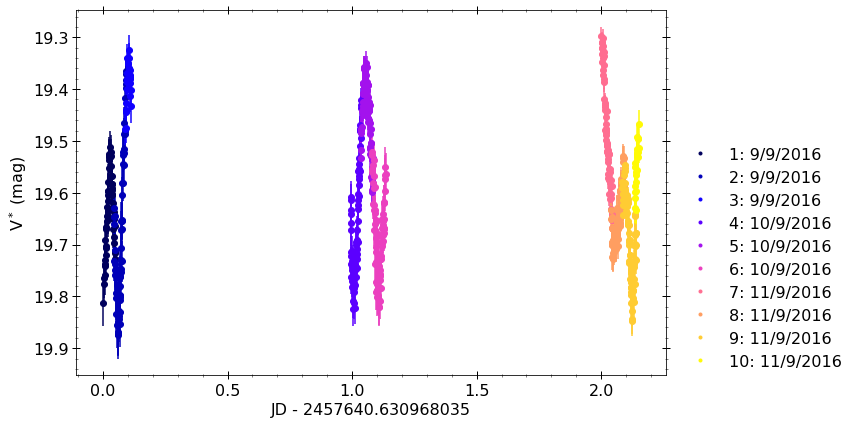

In [10]:
# Correct magnitudes
phot_c, phot_jd_c = [], []
for p in phot:
  new_phot = correction(object_name, p)
  phot_c.append(new_phot)
  phot_jd_c.append(np.mean(new_phot[:,0]))

# Plot light curve
plt.figure(figsize=(12,6))
ax = plt.subplot(1, 1, 1)

x0 = phot_c[0][0,0]
JD,MAG,MAGERR = [],[],[]
for i,meas in enumerate(phot_c):
  x = meas[:,0] - x0
  y, yerr = meas[:,1], meas[:,2]
  JD.extend(x), MAG.extend(y), MAGERR.extend(yerr)
  meas_jd = julian.from_jd(phot_jd_c[i], fmt='jd')
  xlabel, ylabel = 'JD - ' + str(x0), r'V$^*$ (mag)'
  color = co[i+1]
  label = '%i: %i/%i/%i' % (i+1, meas_jd.day, meas_jd.month,meas_jd.year)
  plotter(ax, x, y, yerr, xlabel, ylabel, color, label, fontsize)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
JD = np.array(JD); MAG = np.array(MAG); MAGERR = np.array(MAGERR)

**Figure 3.** Same as Fig. [2](#scrollTo=ssHekV0OGVDj&line=31&uniqifier=1), with magnitude and julian days corrected from distance, phase angle and light time.

Despite having corrected the displacement in the vertical axis, we must still find the asteroid's rotation period. In the next section, a particular Fourier method will be apply to solve this issue.

## **Finding the rotation period**

It is not an objective of this notebook to introduce the foundations of Fourier analysis, so exploring the specialized literature is highly recommended. Nevertheless, a brief description of the method, based in the marvellous paper of [VanderPlas (2018)](#scrollTo=I1JUdFfcUF3f&line=2&uniqifier=1), is explained to make this notebook self-consistent.

### **Introduction to Lomb-Scargle periodogram**

When a continuous function is sampled at regular intervals, the delta functions in the Dirac comb window serve to collapse the Fourier integral into a Fourier sum, and in this manner we can arrive at the common form of the discrete Fourier transform.  Suppose we have a true continous signal g(t), but we observe it only at a regular grid with spacing $\Delta t$ and with finite number of samples N. Its Fourier transform is:

$$
\hat{g}(f) = \sum_{n=0}^N g_n e^{-2 \pi i f n \Delta t}
\quad \quad (4)
$$

We know that the only relevant frequency range is from $0 \leq f \leq 1/\Delta t$, and so we can define N evenly-spaced frequencies with $\Delta f = 1/(N\Delta t)$ covering
this range. Denoting the sampled transform as $\hat{g}k \equiv \hat{g}_{obs}(k\Delta f)$, we can write:

$$
\hat{g}_k = \sum_{n=0}^N g_n e^{-2 \pi i k n/N}
\quad \quad (5)
$$
which is the standard form of the Discrete Fourier Transform (DFT).

With the DFT defined, we can apply the definition of the Fourier power spectrum to compute the classical periodogram:

$$
P(f) = \frac{1}{N}\left|\sum_{n=1}^N g_n e^{-2\pi ift_n}\right|^2  = \frac{1}{N}\left[\left(\sum_{n}g_n cos(2\pi ft_n)\right)^2 + \left(\sum_{n}g_n sin(2\pi ft_n)\right)^2\right] \quad \quad (6)
$$

When the classical periodogram is applied to uniformly-sampled Gaussian noise, the values of the resulting periodogram is $\chi^2$ distributed. This property becomes quite useful in practice when the periodogram is used in the context of a classical hypothesis test to distinguish between periodic and non-periodic objects. Unfortunately, when the sampling becomes nonuniform these properties no longer hold and the periodogram distribution cannot in general be analytically expressed. [Scargle (1982)](#scrollTo=I1JUdFfcUF3f&line=2&uniqifier=1) addressed this by considering a generalized form of the periodogram:

$$
P(f) = \frac{A^2}{2}\left(\sum_{n}g_n cos(2\pi f [t_n-\tau])\right)^2 + \frac{B^2}{2}\left(\sum_{n}g_n sin(2\pi f [t_n-\tau])\right)^2 \quad \quad (7)
$$

where $A$, $B$, and $\tau$ are arbitrary functions of the frequency $f$ and observing times $t_i$ (but not the
values $g_n$).

A remarkable feature of Scargle's modified periodogram is that it is identical to the result obtained by fitting a model consisting of a simple sinusoid to the data at each frequency $f$ and constructing a "periodogram" from the $\chi^2$ goodness-of-fit at each frequency -an estimator which was considered in some depth by [Lomb (1976)](#scrollTo=I1JUdFfcUF3f&line=2&uniqifier=1)-. From this perspective, the $\tau$ shift defined serves to orthogonalize the normal equations used in the least squares analysis. Partly due to this
deep connection between Fourier analysis and least-squares analysis, this modified periodogram has since become commonly referred to as the Lomb-Scargle Periodogram.

In the least squares interpretation of the periodogram,
a combination of $K-1$ sinusoidal components at integer multiples of each candidate fundamental frequency $f$:

$$
y_{model}(t,f) = A_f^0 + \sum_{k=1}^K A_f^k ~sin(2\pi kf[t-\phi_f^k]) \quad \quad (8)
$$

where the amplitude $A_f^k$ and phase $\phi_f^k$ can vary as a function of frequency. These model parameters are fit to the data in the standard least-squares sense, by constructing the $\chi^2$
statistic at each frequency:

$$
\chi^2(f) = (\vec{y}_n - \vec{y}_{model}(t,f))^T \Sigma^{-1}(\vec{y}_n - \vec{y}_{model}(t,f)) \quad \quad (9)
$$

where $\Sigma$ denote the $N\times N$ noise covariance matrix for N observations. [Scargle (1982)](#scrollTo=I1JUdFfcUF3f&line=2&uniqifier=1) showed that with this setup,
the Lomb-Scargle periodogram can be equivalently written:

$$
P(f) = \frac{1}{2}[\hat{\chi}_0^2 - \hat{\chi}^2(f)] \quad \quad (10)
$$

where $\hat{\chi}_0^2$ is the non-varying reference model. Thus, finding the minimum value of $\hat{\chi}^2$ is equivalent to get the maximum of $P(f)$.

The package `astropy` has an implemented function for the getting the Lomb-Scargle periodogram and we will use for this purpose.

Best rotation period: 3.810 hours


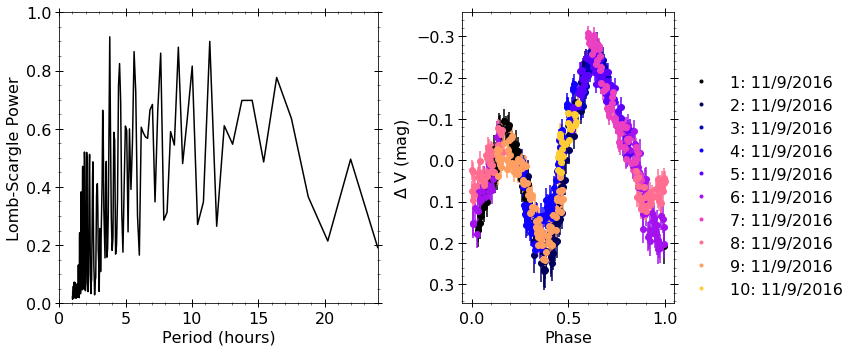

In [11]:
# Get the power spectrum
K = 4      # Number of terms in eq. (8)
ls = LombScargle(JD, MAG, MAGERR, nterms=4)    # Errors are optional
frequency, power = ls.autopower(nyquist_factor=1.5,
                                minimum_frequency=1,maximum_frequency=24)

# Convert the frecuency to period
period_hours = 24/frequency
period_days = 1/frequency

# Find the frecuency of the power maximum
best_freq = frequency[np.argmax(power)]
best_period = period_days[np.argmax(power)]
print('Best rotation period: %.3f hours' % (24*best_period))

# Convert JD to rotation phase
phot_cp = np.array(phot_c)
offset = 0.57
PH = []
for i,p in enumerate(phot_c):
  phase = (p[:,0] / best_period + offset) % 1
  phot_cp[i] = np.column_stack((p,phase))
  PH.extend(phase)
PH = np.array(PH)

# Plot the periodogram and the phase lightcurve
plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1]) 

# Periodogram
ax_pd = plt.subplot(gs[0])
plotter(ax_pd, period_hours, power, None, 'Period (hours)',
        'Lomb-Scargle Power', 'k',
        None, fontsize, mk='None', lstyle='-', rast=True)
ax_pd.set(xlim=(0, 24), ylim=(0, 1))

# Phased light curve
ax_ph = plt.subplot(gs[1])
V_mean = np.mean(MAG)
phase_fit = np.linspace(0,1,5000)
for i,p in enumerate(phot_cp):
  label = '%i: %i/%i/%i' % (i+1, meas_jd.day, meas_jd.month,meas_jd.year)
  plotter(ax_ph, p[:,3], p[:,1]-V_mean, p[:,2], 'Phase', r'$\Delta$ V (mag)',
          co[i], label, fontsize)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Figure 4.** Left: Lomb-Scargle periodogram. Right: Phased light curve of the asteroid 2016 LX48.

### **Estimating uncertainties**

The least squares view of the Lomb-Scargle periodogram creates a natural bridge, via maximum likelihood, to Bayesian periodic analysis. In the Bayesian view, the Lomb-Scargle periodogram is in fact the optimal statistic for detecting a
stationary sinusoidal signal in the presence of Gaussian noise. The Bayesian periodogram is given by the posterior
probability of frequency $f$ given the data $D$ and sinusoidal model $M$:

$$
p(f|D,M) ~\alpha~e^{P(f)} \quad \quad (11)
$$

where $P(f)$ is the Lomb-Scargle power from eq. (10). Thus, we can estimate peak precision by plotting the Bayesian periodogram peak and fitting a Gaussian to it.

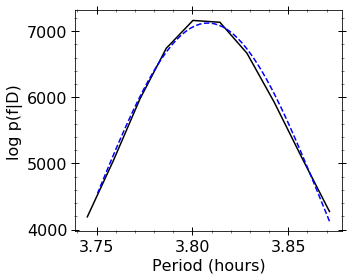

Best rotation period: 3.81 +- 0.06 hours


In [12]:
# Compute the periodogram around mos probable frequency
freq, power = ls.autopower(nyquist_factor=500,minimum_frequency=best_freq-0.1,
                           maximum_frequency=best_freq+0.1,
                    samples_per_peak=20,normalization='psd')

period_hours = 24/freq

# Fit a gaussian curve to the periodogram usin curve_fit
def gaussian(x,a,mu,sigma):
  return a*np.exp(-(x-mu)**2/(2*sigma**2))
popt, pcov = curve_fit(gaussian,period_hours,power_exp)

#Plot the peak and the gaussian fit
plt.figure(figsize=(5,4))
ax = plt.subplot(1, 1, 1)
x = np.linspace(best_freq-0.1,best_freq+0.1,50) 
plotter(ax,period_hours,power,None,'','','k',None, fontsize,mk='None',lstyle='-')
plotter(ax,24/x,gaussian(24/x,*popt),None,'Period (hours)','log p(f|D)','b',
        None,fontsize,mk='None',lstyle='--')
plt.tight_layout()
plt.show()

# Show results
best_P, best_P_err  = np.abs([pt for pt in tuple(popt)])[1:]
print('Best rotation period: %.2f +- %.2f hours' % (best_P, best_P_err))

## **Final result**

One we have estimated the uncertainty for the rotation period we can use the model created to generate the Lomb-Scargle periodogram to fit a combination of sinusoidal components to the dataset and obtain the residuals.

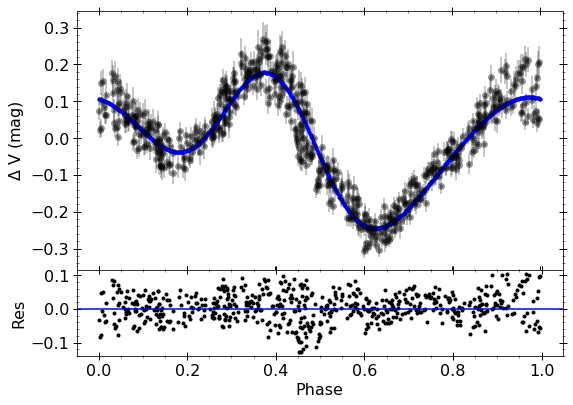

In [13]:
# Compute the model curve
PH_fit = np.linspace(0,1,len(PH))
best_f = 24/best_P
mag_model = ls.model(PH_fit/best_f,best_f)

# Plot the light curve and the fit curve
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_axes([0.2, 0.3, 0.75, 0.6])
ax2 = fig.add_axes([0.2, 0.1, 0.75, 0.2])

plotter(ax1,PH, MAG-V_mean, MAGERR, '', '', 'k', None, fontsize, aph=0.3)
plotter(ax1,PH_fit,mag_model-V_mean, None, 'Phase', r'$\Delta$ V (mag)',
        'b', None, fontsize, lstyle='-')
plt.gca().invert_yaxis()

# Plot the residuals
plotter(ax2,PH,MAG-np.interp(PH,PH_fit,mag_model),None,'Phase','Res','k',None,fontsize)
ax2.axhline(0,0,1,c='b')
plt.gca().invert_yaxis()
plt.show()


-- --
## **References**
> Asphaug, E., Agnor, C. B. & Williams, Q. (2006), [Nature](https://www.nature.com/articles/nature04311), 439, 7073, pp. 155-160.\
Bowell, E., Hapke, B., Domingue D., et al. (1989), [Asteroids II](https://ui.adsabs.harvard.edu/abs/1989aste.conf..524B), pp. 524-556.\
Chapman, C. R. (2004), [EPSL](https://www.sciencedirect.com/science/article/pii/S0012821X04001761?via%3Dihub), 222, 1, pp. 1-15.\
Lomb, N. R. (1976), [Astrophys. Space Sci.](https://ui.adsabs.harvard.edu/abs/1976Ap&SS..39..447L), 39, 2, pp. 447-462.\
Rivkin, A. S. & Emery, J. P. & Williams, Q. (2010), [Nature](https://www.nature.com/articles/nature09028), 464, 7293, pp. 1322-1323.\
Scargle, J. D. (1982), [ApJ](https://ui.adsabs.harvard.edu/abs/1982ApJ...263..835S/abstract), 263, pp. 835-853.\
VanderPlas, J. T. (2018), [ApJ](https://iopscience.iop.org/article/10.3847/1538-4365/aab766), 236, 1, pp. 16.

